In [2]:
from pathlib import Path
import torchvision.models as models
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import numpy as np
from torch_lr_finder import LRFinder
import os

In [3]:
import pixiedust
import torch
from torch import nn
import pathlib
from torch.utils.data import DataLoader
from torchvision import *

Pixiedust database opened successfully


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.empty_cache()

In [6]:
transformtrain= transforms.Compose([
    transforms.Resize((124,124)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),              #convert the value to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])         # convert all the value form -1 to 1 for all RGB
])

In [7]:
transformvalid= transforms.Compose([
    transforms.Resize((124,124)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #convert the value to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])         # convert all the value form -1 to 1 for all RGB
])

In [8]:
model = models.resnet18(pretrained=True).to(device)

In [9]:
traindata=datasets.ImageFolder('seg_train/seg_train' , transform=transformtrain)

In [10]:
valdata=datasets.ImageFolder('seg_test/seg_test', transform=transformvalid)

In [11]:
trainloader=DataLoader(traindata, batch_size=64, shuffle=True)

In [12]:
 #next(iter(trainloader))

In [13]:
valloader=DataLoader(valdata,batch_size=64,shuffle=True)

In [14]:
len(valloader)

47

In [15]:
classes=['buildings','forest','glacier','mountain','sea','street']

In [16]:
noclass=len(classes)

In [17]:

for param in model.parameters():
    param.requires_grad=False

In [18]:
# for param in model.parameters():
#     print(param)

In [19]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
model.fc=nn.Linear(model.fc.in_features,noclass).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.000001)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



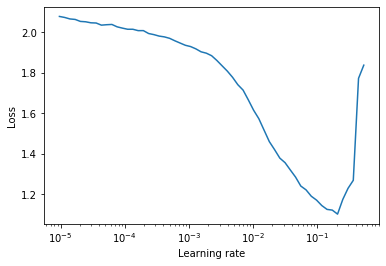

In [21]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=150, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [50]:
# optimizer=torch.optim.Adam(model.parameters(),lr=0.00001)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(trainloader, val_loader=valloader, end_lr=100, num_iter=100, step_mode="linear")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

In [22]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.0005)

In [23]:
optimizer.zero_grad()

In [24]:
def accuracy(out, yb): 
    return (torch.argmax(out, dim=1)==yb).float().mean()
#%%pixie_debugger

In [25]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    tloss=[]
    vloss=[]
    
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        tot_train=0
#         print(model.training)
        for xb,yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_func(model(xb), yb)
            tot_train+=loss
            loss.backward()
            opt.step()
            opt.zero_grad()
        nt=len(train_dl)
        
        
        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        tloss.append(tot_train/nt)
        vloss.append(tot_loss/nv)
        print(epoch,tot_train/nt, tot_loss/nv, tot_acc/nv)
    return tloss, vloss

In [26]:
ltrain,lval = fit(6, model, criterion, optimizer, trainloader, valloader)

0 tensor(0.8280, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.4978, device='cuda:0') tensor(0.8432, device='cuda:0')
1 tensor(0.4557, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.4229, device='cuda:0') tensor(0.8604, device='cuda:0')
2 tensor(0.4056, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.4007, device='cuda:0') tensor(0.8605, device='cuda:0')
3 tensor(0.3756, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3811, device='cuda:0') tensor(0.8699, device='cuda:0')
4 tensor(0.3537, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3577, device='cuda:0') tensor(0.8774, device='cuda:0')
5 tensor(0.3474, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3652, device='cuda:0') tensor(0.8703, device='cuda:0')


In [27]:
ltrain

[tensor(0.8280, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4557, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4056, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3756, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3537, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3474, device='cuda:0', grad_fn=<DivBackward0>)]

In [35]:
path="C:/Users/Iconsense/Documents/virat/abhi"
torch.save(model.state_dict(), path)

PermissionError: [Errno 13] Permission denied: 'C:/Users/Iconsense/Documents/virat/abhi'

In [36]:
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
# modelB.load_state_dict(checkpoint['modelB_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimizerB.load_state_dict(checkpoint['optimizerB_state_dict'])

# modelA.eval()
# modelB.eval()
# # - or -
model.train()
# modelB.train()

PermissionError: [Errno 13] Permission denied: 'C:/Users/Iconsense/Documents/virat/abhi'

In [37]:
lval

[tensor(0.4978, device='cuda:0'),
 tensor(0.4229, device='cuda:0'),
 tensor(0.4007, device='cuda:0'),
 tensor(0.3811, device='cuda:0'),
 tensor(0.3577, device='cuda:0'),
 tensor(0.3652, device='cuda:0')]

In [38]:
# tloss=np.array(losstrain)
# vloss=np.array(lossval)

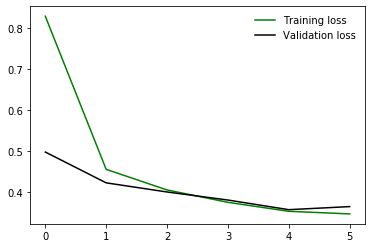

In [39]:
plt.plot(ltrain, label='Training loss', color='green')
plt.plot(lval, label='Validation loss', color ='black')
plt.legend(frameon=False)
plt.show()

In [40]:
from PIL import Image
import numpy as np

In [41]:
img = Image.open('seg_pred/seg_pred/3966.jpg')

In [42]:
nimg = np.array(img)

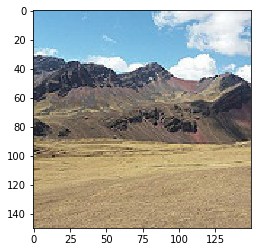

In [43]:
plt.imshow(nimg)


In [55]:
nimg = transformvalid(img).unsqueeze(0).to(device)

In [56]:
nimg.shape

torch.Size([1, 3, 124, 124])

In [57]:
prediction = model(nimg)

In [58]:
_, tpredict = torch.max(prediction.data, 1)

In [59]:
classes[tpredict[0].item()]

'sea'

In [60]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
for param in model.parameters():
    param.requires_grad = True
optimizer=torch.optim.Adam(model.parameters(),lr=0.00000001)   
"""optimizer = torch.optim.Adam([{'params': model.layer4.parameters()},
                {'params': model.layer1.parameters(), 'lr': 1e-2},
                {'params': model.layer2.parameters(), 'lr': 1e-4},
            
            ], lr=1e-1)"""

"optimizer = torch.optim.Adam([{'params': model.layer4.parameters()},\n                {'params': model.layer1.parameters(), 'lr': 1e-2},\n                {'params': model.layer2.parameters(), 'lr': 1e-4},\n            \n            ], lr=1e-1)"

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



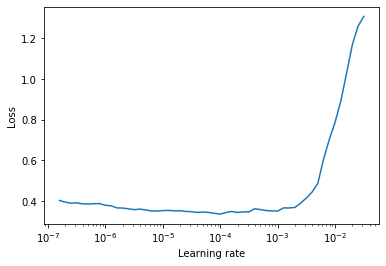

In [62]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [66]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam([{'params': model.layer4.parameters()},
                {'params': model.layer1.parameters(), 'lr': 5e-7},
                 {'params': model.layer2.parameters(), 'lr': 1e-6},
                {'params': model.layer3.parameters(), 'lr': 1e-5}
            ], lr=1e-4)

In [67]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    tloss=[]
    vloss=[]
    
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        tot_train=0
#         print(model.training)
        for xb,yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_func(model(xb), yb)
            tot_train+=loss
            loss.backward()
            opt.step()
            opt.zero_grad()
        nt=len(train_dl)
        
        
        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        tloss.append(tot_train/nt)
        vloss.append(tot_loss/nv)
        print(epoch,tot_train/nt, tot_loss/nv, tot_acc/nv)
    return tloss, vloss

In [68]:
ltrain,lval = fit(6, model, criterion, optimizer, trainloader, valloader)

0 tensor(0.0353, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2867, device='cuda:0') tensor(0.9277, device='cuda:0')
1 tensor(0.0212, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3138, device='cuda:0') tensor(0.9247, device='cuda:0')
2 tensor(0.0189, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3912, device='cuda:0') tensor(0.9130, device='cuda:0')
3 tensor(0.0213, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3768, device='cuda:0') tensor(0.9201, device='cuda:0')
4 tensor(0.0161, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3603, device='cuda:0') tensor(0.9233, device='cuda:0')
5 tensor(0.0170, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3613, device='cuda:0') tensor(0.9261, device='cuda:0')


In [245]:
# criterion = nn.CrossEntropyLoss()
# optimizer=torch.optim.Adam(model.parameters(),lr=0.000001)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(trainloader, val_loader=valloader, end_lr=1, num_iter=100, step_mode="linear")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

In [246]:
# for param in model.features.parameters():
#     param.requires_grad = True
    
# optimizer = torch.optim.Adam([{'params': model.classifier.parameters()},
#                 {'params': model.features.parameters(), 'lr': 0.00001}
#             ], lr=0.002)

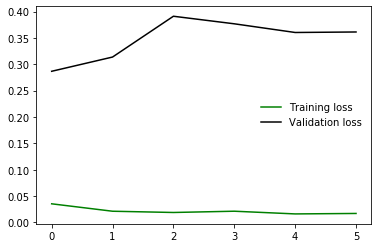

In [69]:

plt.plot(ltrain, label='Training loss', color='green')
plt.plot(lval, label='Validation loss', color ='black')
plt.legend(frameon=False)
plt.show()